#### Решающие деревья, ансамбли и бустинг

Датасет: [Bank Marketing Dataset](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset) (предсказание, подпишется ли клиент на депозит)

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

In [ ]:
path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")
files = os.listdir(path)
csv_files = [f for f in files if f.endswith('.csv')]
csv_path = os.path.join(path, csv_files[0])
data = pd.read_csv(csv_path)

In [ ]:
data2=data.copy()

Я поняла это только на 2 задании, когда построила решающее дерево: топовым признаком является duration на верхнем и нескольких нижних уровнях, но ведь у duration есть большая проблема - во-первых, если duration=0, то мы однозначно знаем, что ответ нет, а во-вторых, мы не можем знать на момент предсказания длину звонка, а знаем только после, когда уже знаем и ответ. Вроде нигде в задании об этом не написано, но я решила удалить этот признак заранее

In [ ]:
data=data.drop('duration', axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  campaign   11162 non-null  int64 
 12  pdays      11162 non-null  int64 
 13  previous   11162 non-null  int64 
 14  poutcome   11162 non-null  object
 15  deposit    11162 non-null  object
dtypes: int64(6), object(10)
memory usage: 1.4+ MB


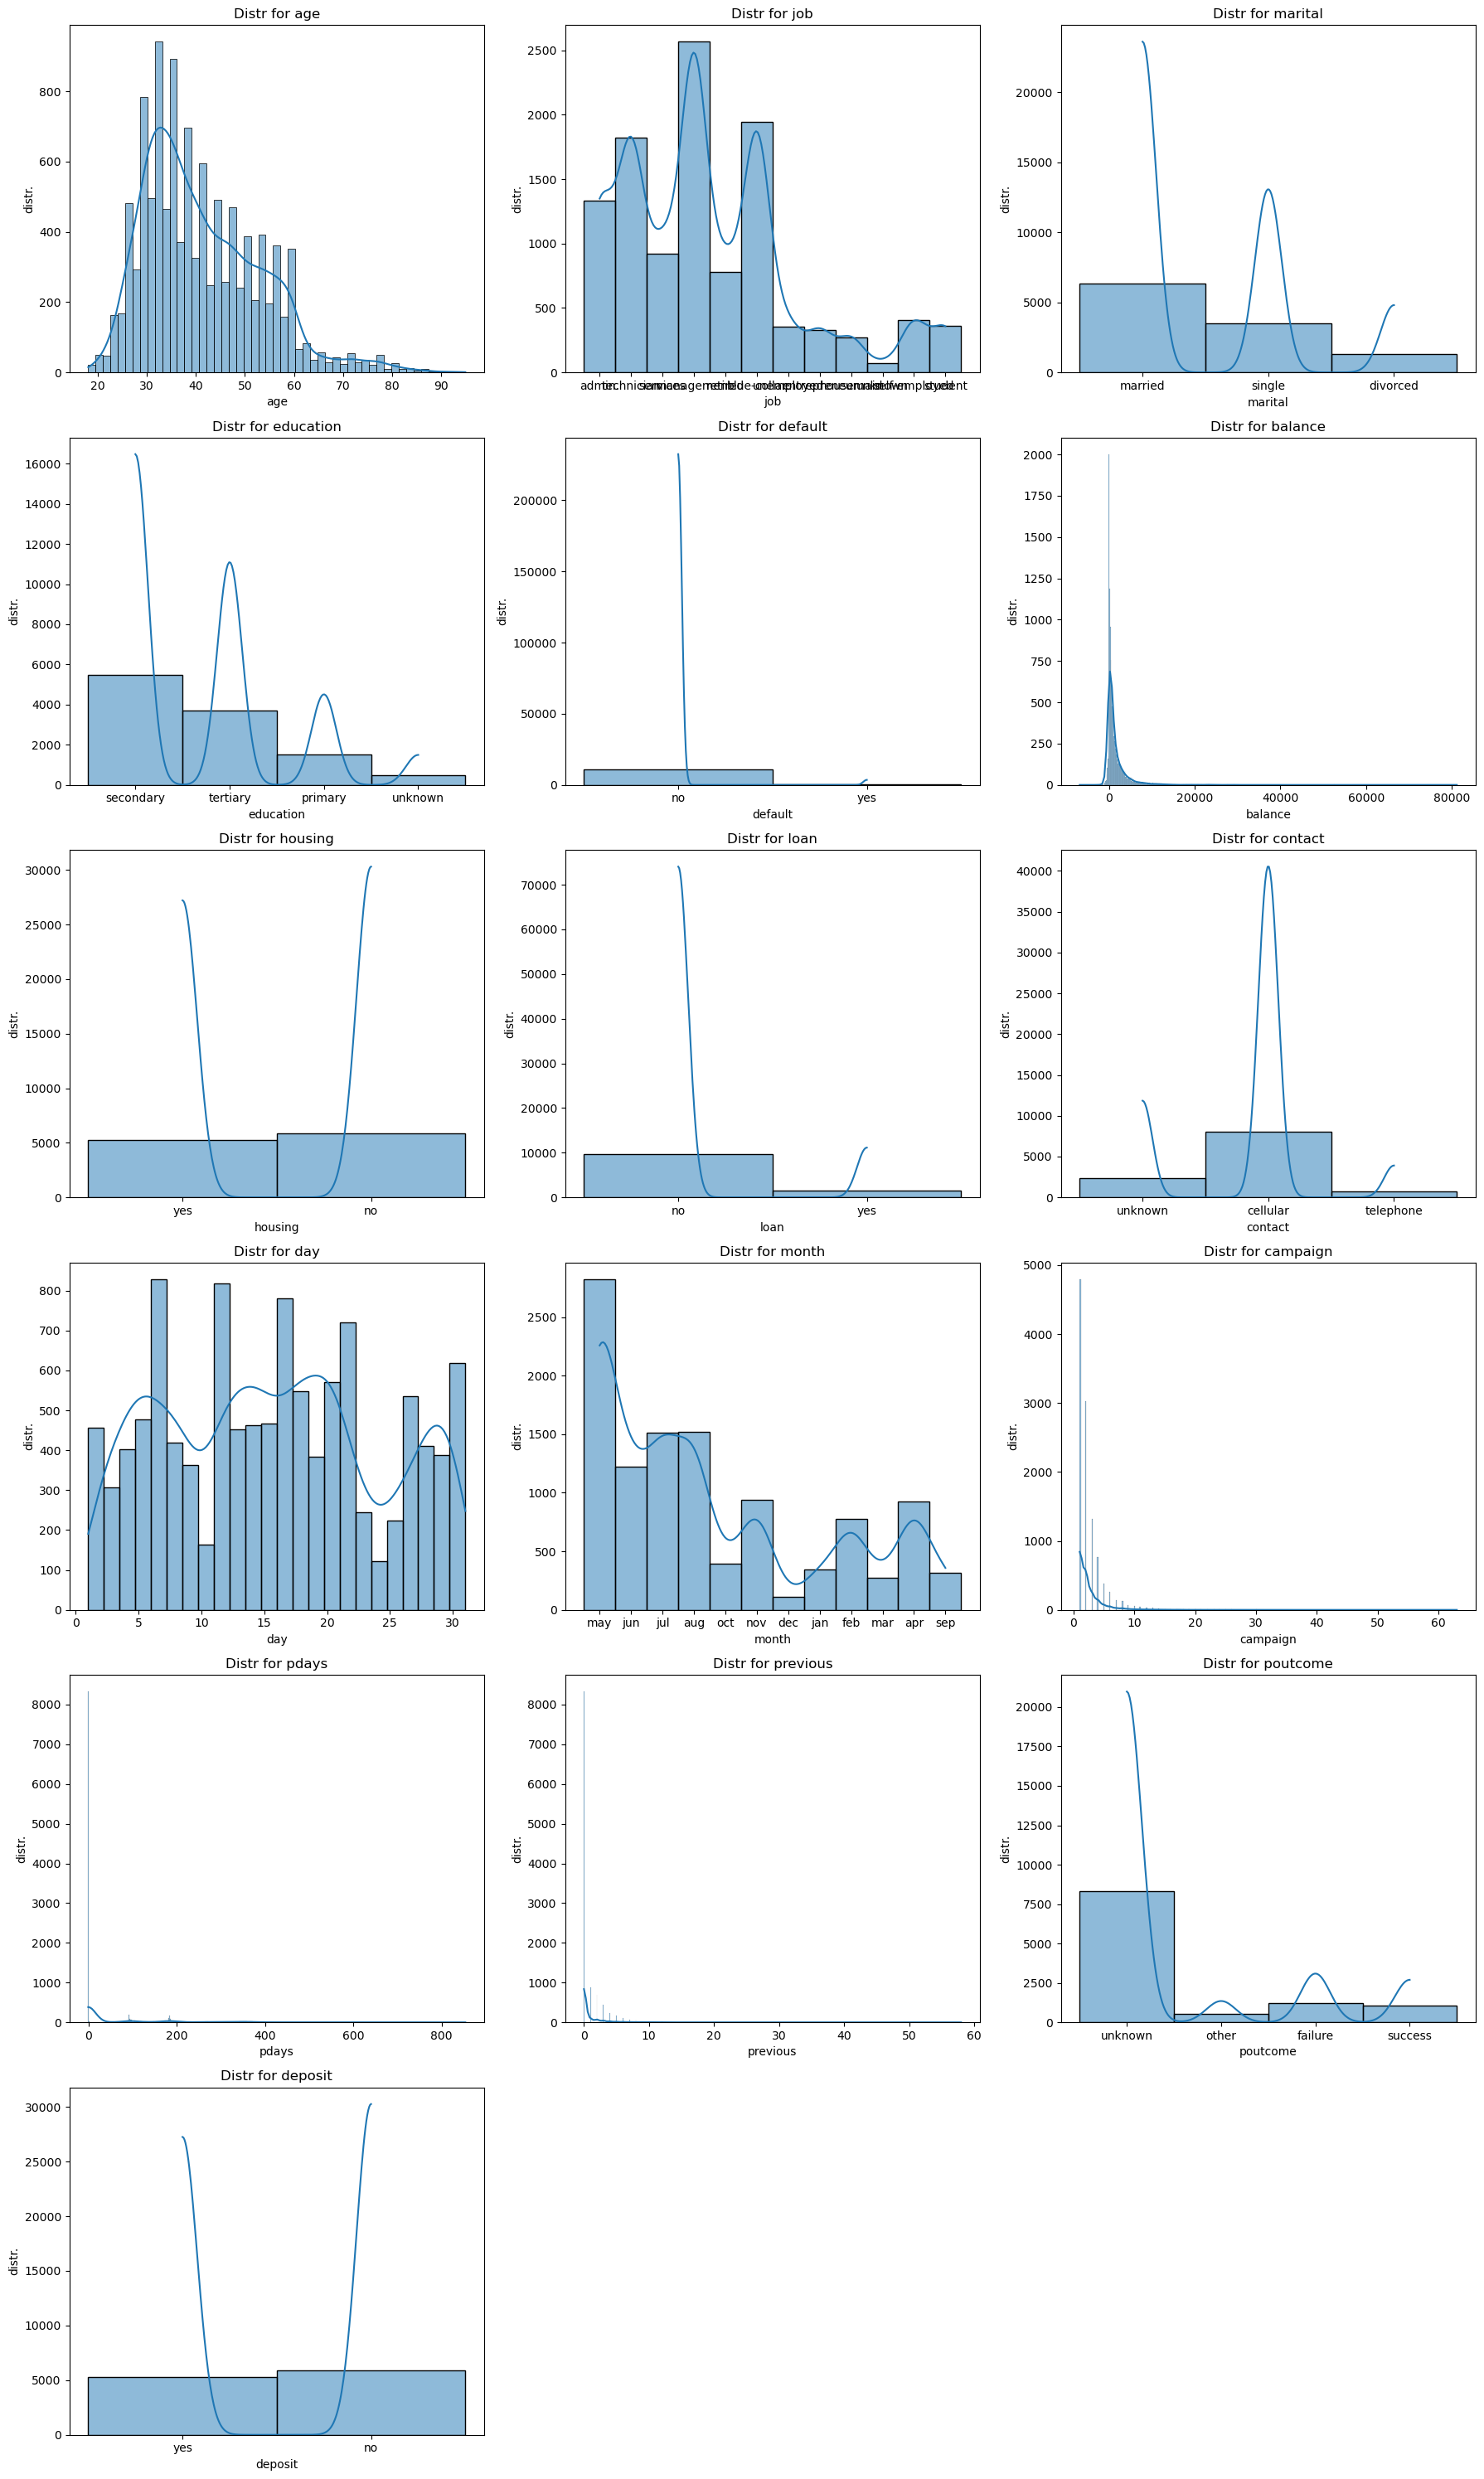

In [ ]:
data.info()

data.describe()

plt.figure(figsize=(18, 5*((data.shape[1]+2)//3)))
for i, col in enumerate(data.columns):
    plt.subplot((data.shape[1]+2)//3, 3, i+1)
    sns.histplot(data, x=col, kde=True)
    plt.xlabel(col)
    plt.ylabel('distr.')
    plt.title(f'Distr for {col}')

plt.tight_layout()
plt.show()

Да: 5289, (0.4738 %); Нет: 5873, (0.5262 %)


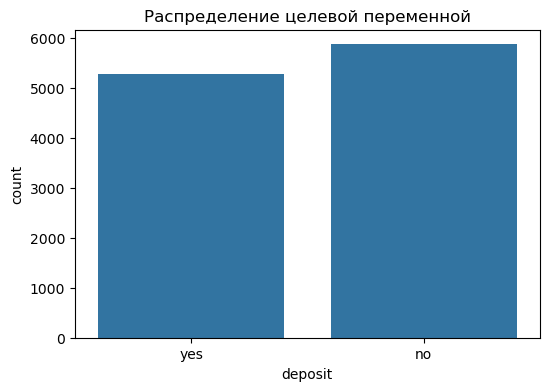

In [ ]:
yes=len(data[data['deposit']=='yes'])
no=len(data[data['deposit']=='no'])
print(f"Да: {yes}, ({yes/data.shape[0]:.4f} %); Нет: {no}, ({no/data.shape[0]:.4f} %)")

plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='deposit')
plt.title('Распределение целевой переменной')
plt.show()

In [ ]:
data.shape

(11162, 16)

Явных пропусков нет, но есть unknown :

In [ ]:
for col in data.columns:
    count = 0
    if data[col].dtype == 'object':
        count +=(data[col].str.lower() == 'unknown').sum()

    if count> 0:
        print(f"{col}: {count}, {count/111.62:.1f} %")


job: 70, 0.6 %
education: 497, 4.5 %
contact: 2346, 21.0 %
poutcome: 8326, 74.6 %


вот мои идеи: ахах я честно так и не поняла, нужно ли "unknown" считать за пропуски, но решила удалить только в job эти строчки, в остальных всё оставила как есть

In [ ]:
data=data.drop(data[data['job'].str.lower() == 'unknown'].index)

In [ ]:
from sklearn.model_selection import train_test_split
X=data.drop('deposit', axis=1)
y=data['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.preprocessing import LabelEncoder

les={}
cat_feat=X_train.select_dtypes(include=['object', 'category']).columns.to_list()
for col in cat_feat:
    le=LabelEncoder()
    X_train[col]=le.fit_transform(X_train[col])
    les[col]=le

for col in cat_feat:
    X_test[col]=les[col].transform(X_test[col])

Часть 1:

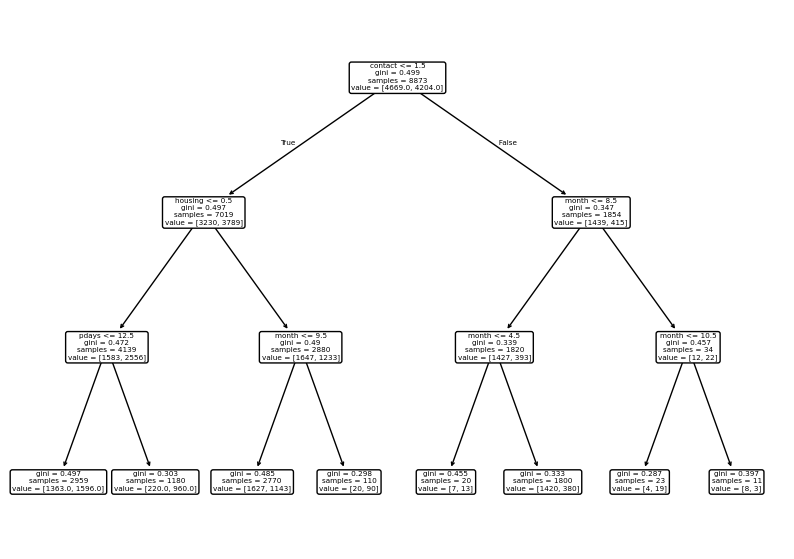

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt=DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
y_pred=dt.predict(X_test)
y_pred_proba=dt.predict_proba(X_test)

plt.figure(figsize=(10, 7))
plot_tree(dt, feature_names=X_train.columns.tolist(), rounded=True)
plt.show()

In [ ]:
fts = dt.feature_importances_
cols = X_train.columns
fts_cols = pd.DataFrame({
    'ft' : cols, 'importance' : fts})

fts_cols=fts_cols.sort_values(by='importance', ascending=False)
fts_cols.head(5)

,ft,importance
8,contact,0.487331
12,pdays,0.211066
6,housing,0.202784
10,month,0.098819
0,age,0.000000


Ответ на вопрос: 3 главных фичи = contact, month, pdays. Больше всего точек содержится в листе с 2959 объектами, при этом gini=0.497 (т.е. очень высоким) и распределнием семплов как [1363 1596]
(PS.: видим проблему!! сумма по importance вообще 1, а у нас уже первые 4 признака в сумме дают 0.(9), а дальше идут только 0. Возможно, как раз-таки потому, что у нас всего одно дерево, дальше в Randomforeste такого не будет)

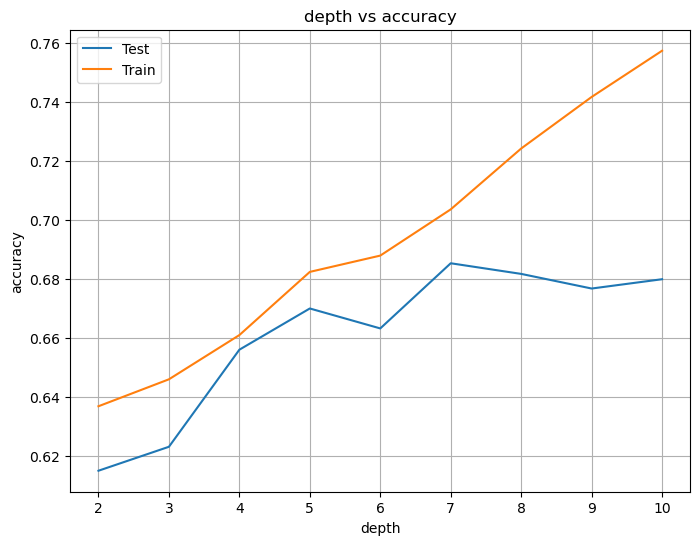

In [ ]:
from sklearn.metrics import accuracy_score

depth = [i for i in range(2, 11)]
accs = np.array([])
accs2 = np.array([])
for i in range(2, 11):
    dt=DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train, y_train)
    y_pred=dt.predict(X_test)
    y_pred_proba=dt.predict_proba(X_test)
    accs=np.append(accs, accuracy_score(y_pred, y_test))
    y_pred2=dt.predict(X_train)
    y_pred2_proba=dt.predict_proba(X_train)
    accs2=np.append(accs2, accuracy_score(y_train, y_pred2))

plt.figure(figsize=(8, 6))
plt.plot(depth, accs, label='Test')
plt.plot(depth, accs2, label='Train')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.title('depth vs accuracy')
plt.grid()
plt.show()

Переобучение наблюдается после max_depth=7, при >=8 accuracy уже начинает снижаться. Логично, что, при увеличении max_depth accuracy на трейне растет, так как дерево просто рассматривает всевозможные варианты и количество точек в каждом листе уменьшается.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100, random_state = 42)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
rf_acc= accuracy_score(y_pred, y_test)
y_pred2=rf.predict(X_train)
rf2_acc= accuracy_score(y_pred2, y_train)
prev_tst=accs[5]
prev_tr=accs2[5]

In [ ]:
print(rf_acc, rf2_acc)

0.7156376746282109 1.0


In [ ]:
ans1=(rf_acc/prev_tst)*100 - 100
print(f"На сколько процентов улучшилась accuracy? - {ans1:.2f} % (было {prev_tst:.3f} - стало {rf_acc:.3f}) ")
print(f"Как изменилось переобучение? - разница между tr/test: было {prev_tr-prev_tst:.2f} - стало {rf2_acc-rf_acc:.2f}; отношение test/tr: было {prev_tr/prev_tst:.2f} - стало { rf2_acc/rf_acc:.2f}")

На сколько процентов улучшилась accuracy? - 4.40 % (было 0.685 - стало 0.716) 
Как изменилось переобучение? - разница между tr/test: было 0.02 - стало 0.28; отношение test/tr: было 1.03 - стало 1.40


Очевидно, переобучение больше, так как я не определяю никаких гиперпараметров и дерево идеально подстраиывается под train. (PS Я изначально сделала gridsearch, но это практически не улучшило значение на тесте, поэтому я убрала , так как не просилось в задании)

In [ ]:
fts = rf.feature_importances_
cols = X_train.columns
fts_cols = pd.DataFrame({
    'ft' : cols, 'importance' : fts})

fts_cols=fts_cols.sort_values(by='importance', ascending=False)
fts_cols.head(7)

,ft,importance
5,balance,0.177284
0,age,0.150901
9,day,0.133066
10,month,0.095558
1,job,0.074001
11,campaign,0.068354
8,contact,0.051063


Итог : и там, и там в топ5 входят month, age, из нового в топе RandomForest появились balance, day, job;
топ5 фичей может отличаться просто потому что мы перебрали 100 деревьев с разными выборками признаков и уловили что некоторые новые лучше; В решающем дереве признаки отбираются жадно, что может помешать увидеть несколько важных кореллированных признаков, например

Часть 3: Градиентный бустинг





In [ ]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
print('1')
data2=data2.drop('duration', axis=1)

1


In [ ]:
from catboost import CatBoostClassifier

data3=data2.copy()
X=data2.drop('deposit', axis=1)
y=data2['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
cat_feat=X_train.select_dtypes(include=['object', 'category']).columns.to_list()

lrs = [0.01, 0.1, 0.3]
for lr in lrs:
    model = CatBoostClassifier(random_state=42, learning_rate=lr, iterations=500,  early_stopping_rounds=50,verbose=50 )
    model.fit(X_train, y_train, cat_features = cat_feat)
    y_pred=model.predict(X_test)
    print(accuracy_score(y_pred, y_test))

0:	learn: 0.6911043	total: 45.6ms	remaining: 22.7s
50:	learn: 0.6153962	total: 2.19s	remaining: 19.3s
100:	learn: 0.5814275	total: 3.94s	remaining: 15.6s
150:	learn: 0.5649042	total: 5.78s	remaining: 13.4s
200:	learn: 0.5547031	total: 7.63s	remaining: 11.3s
250:	learn: 0.5476788	total: 9.39s	remaining: 9.31s
300:	learn: 0.5426376	total: 11.1s	remaining: 7.31s
350:	learn: 0.5386720	total: 12.5s	remaining: 5.29s
400:	learn: 0.5347736	total: 13.9s	remaining: 3.44s
450:	learn: 0.5312571	total: 15.4s	remaining: 1.67s
499:	learn: 0.5286181	total: 16.8s	remaining: 0us
0.735333631885356
0:	learn: 0.6738814	total: 35.3ms	remaining: 17.6s
50:	learn: 0.5298347	total: 1.45s	remaining: 12.7s
100:	learn: 0.5122688	total: 2.86s	remaining: 11.3s
150:	learn: 0.4898881	total: 4.33s	remaining: 10s
200:	learn: 0.4749007	total: 5.86s	remaining: 8.71s
250:	learn: 0.4625970	total: 7.44s	remaining: 7.38s
300:	learn: 0.4514542	total: 9.13s	remaining: 6.04s
350:	learn: 0.4395158	total: 10.8s	remaining: 4.59s
40

Лучше всего accuracy у lr=0.1, acc=0.742

Accuracy было 0.714, стало 0.742

In [ ]:
fts2 = model.feature_importances_
cols2 = X_train.columns
fts_cols2 = pd.DataFrame({
    'ft' : cols2, 'importance' : fts2})

fts_cols2=fts_cols2.sort_values(by='importance', ascending=False)
(fts_cols2.head(5))

,ft,importance
10,month,15.007237
5,balance,13.261196
9,day,12.924596
1,job,10.435466
0,age,10.117226


Топ, те же самые признаки

In [ ]:
#target encoding

X=data3.drop('deposit', axis=1)
y=data3['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
cat_feat=X_train.select_dtypes(include=['object', 'category']).columns.to_list()

model = CatBoostClassifier(random_state=42, learning_rate=0.1, iterations=500,  early_stopping_rounds=50,verbose=50, max_ctr_complexity=1, simple_ctr='Counter')
model.fit(X_train, y_train, cat_features = cat_feat)
y_pred=model.predict(X_test)
print(accuracy_score(y_pred, y_test))

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.


0:	learn: 0.6774041	total: 37.7ms	remaining: 18.8s
50:	learn: 0.5344722	total: 2.08s	remaining: 18.3s
100:	learn: 0.5062067	total: 3.75s	remaining: 14.8s
150:	learn: 0.4819892	total: 5.45s	remaining: 12.6s
200:	learn: 0.4621995	total: 7.18s	remaining: 10.7s
250:	learn: 0.4452073	total: 8.82s	remaining: 8.75s
300:	learn: 0.4304325	total: 10.4s	remaining: 6.85s
350:	learn: 0.4159081	total: 11.9s	remaining: 5.05s
400:	learn: 0.4027950	total: 13.3s	remaining: 3.27s
450:	learn: 0.3912340	total: 14.6s	remaining: 1.59s
499:	learn: 0.3798592	total: 15.9s	remaining: 0us
0.729064039408867


In [ ]:
#one_hot encoding

X=data3.drop('deposit', axis=1)
y=data3['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
cat_feat=X_train.select_dtypes(include=['object', 'category']).columns.to_list()

model = CatBoostClassifier(random_state=42, learning_rate=0.1, iterations=500,  early_stopping_rounds=50,verbose=50, one_hot_max_size=8)
model.fit(X_train, y_train, cat_features = cat_feat)
y_pred=model.predict(X_test)
print(accuracy_score(y_pred, y_test))

0:	learn: 0.6701407	total: 39.2ms	remaining: 19.6s
50:	learn: 0.5270381	total: 2.03s	remaining: 17.9s
100:	learn: 0.5021715	total: 3.73s	remaining: 14.7s
150:	learn: 0.4806420	total: 5.47s	remaining: 12.7s
200:	learn: 0.4602975	total: 7.45s	remaining: 11.1s
250:	learn: 0.4453189	total: 9.38s	remaining: 9.31s
300:	learn: 0.4324940	total: 10.9s	remaining: 7.2s
350:	learn: 0.4185426	total: 12.3s	remaining: 5.21s
400:	learn: 0.4051080	total: 13.7s	remaining: 3.37s
450:	learn: 0.3927560	total: 15.4s	remaining: 1.67s
499:	learn: 0.3805994	total: 16.9s	remaining: 0us
0.74205105239588


Выводы:

В борьбе target vs one hot encoding выиграл one hot encoding! :)